In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 4.3 MB/s 
     |████████████████████████████████| 120 kB 56.9 MB/s 
     |████████████████████████████████| 6.6 MB 40.8 MB/s 


In [ ]:
import numpy as np 
import pandas as pd 

from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from transformers import DistilBertTokenizerFast

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/SPAM_text.csv')

In [ ]:
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
Spam = df['Category'].values
Spam_desc = df['Message'].values

In [ ]:
print(len(df.Category.unique()))

2


In [ ]:
Spamdesc_X_raw, Category_Y_raw = shuffle(Spam_desc, Spam, random_state=0)

In [ ]:
Category_enc = LabelEncoder()
Y_Category =  Category_enc.fit_transform(Category_Y_raw)

In [ ]:
Y_Category.shape

(5572,)

In [ ]:
#sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
sss = StratifiedKFold(n_splits=5)

In [ ]:
for train_index, test_index in sss.split(Spamdesc_X_raw, Y_Category):
  X_train, X_test = Spamdesc_X_raw[train_index], Spamdesc_X_raw[test_index]
  y_train, y_test = Y_Category[train_index], Y_Category[test_index]  

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True)


In [ ]:
import torch

class SpamDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = SpamDataset(train_encodings, y_train.tolist())

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
from torch.utils.data import DataLoader
from transformers import DistilBertForSequenceClassification, AdamW

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(df.Category.unique()))
model.to(device)
model.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#optim = torch.optim.Adam(model.parameters(),lr=1e-6)
optim = AdamW(model.parameters(), lr=3e-5)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [21]:
step = 0
dt1 = datetime.now()
for epoch in range(1):
  for batch in train_loader:
    optim.zero_grad()
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs[0]
    loss.backward()
    optim.step()
    labels.detach()
    del labels
    attention_mask.detach()
    del attention_mask
    input_ids.detach()
    del input_ids
    step += 1
    if step % 100 == 0:
      dt2 = datetime.now()
      print(str(step) + ': loss = {} '.format(loss.item()) + '({})'.format((dt2-dt1)))
      dt1 = datetime.now()
      torch.cuda.empty_cache()
  print("epoch finished: " + str(epoch))    

100: loss = 0.022808987647294998 (1:01:08.025832)
epoch finished: 0


In [22]:
torch.cuda.empty_cache()

In [23]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [24]:
from tqdm import tqdm

In [25]:
y_pred = []
for x in tqdm(X_test.tolist()):
  test_encoding = tokenizer(x, truncation=True, padding=True, return_tensors="pt").to(device)
  y_pred.append(np.argmax(model(**test_encoding)['logits'].detach().to('cpu').numpy()).tolist())
  test_encoding['input_ids'].detach()
  test_encoding['attention_mask'].detach()
  del test_encoding['input_ids']
  del test_encoding['attention_mask']
  del test_encoding
  torch.cuda.empty_cache()

100%|██████████| 1114/1114 [01:23<00:00, 13.34it/s]


In [26]:
f1_score(y_test, y_pred, average='macro') # (3 epoch)

0.988312069833809

In [27]:
f1_score(y_test, y_pred, average='macro') # (10 epoch)

0.988312069833809

In [28]:
# test model akurasi di test confusion matrix

from sklearn.metrics import confusion_matrix
cm= confusion_matrix(y_test, y_pred)

TP = cm[0][0]
TN = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]

print(cm)
print('Testing Akurasi =' ,(TP + TN)/ (TP+TN+FN+FP))

[[963   2]
 [  4 145]]
Testing Akurasi = 0.9946140035906643


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(33.0, 0.5, 'Actual')

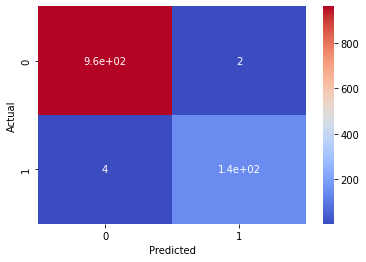

In [30]:
sns.heatmap(cm, annot=True, cmap='coolwarm')
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [31]:
# cara lain mendapatkan matrix models
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print( classification_report(y_test, y_pred))
print( accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       965
           1       0.99      0.97      0.98       149

    accuracy                           0.99      1114
   macro avg       0.99      0.99      0.99      1114
weighted avg       0.99      0.99      0.99      1114

0.9946140035906643
